In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# import custom libraries
import sys
sys.path.append("C:\\DATA\\Tasks\\lib\\hk")
import hk_psql

import plotly.express as px  # (version 4.7.0 or higher)
import plotly.graph_objects as go
from plotly.subplots import make_subplots



import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from pytorch_lightning.loggers import TensorBoardLogger

import optuna
from optuna.integration import PyTorchLightningPruningCallback

ADD_DATA = "C:\\DATA\\data\\raw\\physionet_challenge_2019\\"

%load_ext autoreload
%autoreload 2




## Data preprocessing for LSTM

In [ ]:
### Imputation

In [294]:
df_train = pd.read_csv(ADD_DATA+'df_AA.csv')
df_valid = pd.read_csv(ADD_DATA+'df_BB.csv')


#df_train['prev_sepsis'] = df_train['SepsisLabel'].shift(periods=7).bfill()
#df_valid['prev_sepsis'] = df_valid['SepsisLabel'].shift(periods=7).bfill()
df_train.columns


Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'id'],
      dtype='object')

In [295]:
# extract missingness pattern
cols_ts = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']


a = ((df_train[cols_ts].isnull().sum() / len(df_train) * 100)>80)
cols_irreg = a[a==True].index.tolist()

cols_patt = [col+'_pattern' for col in cols_irreg]
cols_count = [col+'_count' for col in cols_irreg]

for col in cols_irreg:
    df_train[col+'_pattern'] = df_train[col].notnull().astype(int)
    df_valid[col+'_pattern'] = df_valid[col].notnull().astype(int)
    
    a = df_train.groupby('id')[col+'_pattern'].rolling(min_periods=1, window=6).sum().reset_index(drop=True)
    df_train[col+'_count'] = a

    a = df_valid.groupby('id')[col+'_pattern'].rolling(min_periods=1, window=6).sum().reset_index(drop=True)
    df_valid[col+'_count'] = a

df_train['all_counts'] = df_train[cols_count].sum(axis=1)
df_valid['all_counts'] = df_valid[cols_count].sum(axis=1)

In [269]:
a = df_train.groupby('id')['Lactate'+'_pattern'].rolling(min_periods=1, window=6).sum().reset_index(drop=True)
df = pd.DataFrame()
df['Lactate'] = df_train['Lactate']
df['id'] = df_train['id']
df['c'] = df_train.groupby('id')['Lactate'+'_pattern'].rolling(min_periods=1, window=6).sum().reset_index(drop=True)

In [270]:
# a link for imputation tutorial
# https://towardsdatascience.com/how-to-fill-missing-data-with-pandas-8cb875362a0d

cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets','HospAdmTime','ICULOS','Age']


df_train[cols] = df_train.groupby('id')[cols].ffill().bfill()
df_train[cols] = df_train[cols].fillna( df_train[cols].mean() )
df_train[cols] = df_train[cols].fillna( 0 )

df_valid[cols] = df_valid.groupby('id')[cols].ffill().bfill()
df_valid[cols] = df_valid[cols].fillna( df_valid[cols].mean() )
df_valid[cols] = df_valid[cols].fillna( 0 )

mean_train = df_train[cols].mean().tolist()
std_train = df_train[cols].std().tolist()

#print(df_train.isnull().sum())
#print(df_train[cols].mean(), df_train[cols].std())

df_train[cols]=(df_train[cols]-df_train[cols].mean())/df_train[cols].std()
df_valid[cols]=(df_valid[cols]-df_train[cols].mean())/df_train[cols].std()

#print(df_train[cols].mean(), df_train[cols].std())


print(df_train[cols].isnull().sum())
print(df_train[cols].isnull().sum())


HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
HospAdmTime         0
ICULOS              0
Age                 0
dtype: int64
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
BaseExcess          0
HCO3               

In [296]:

for col in cols:
    df_train[col] = pd.qcut(df_train[col], 3, labels=['L','N','H'])
    df_train[col] = df_train[col].cat.codes
    df_valid[col] = pd.qcut(df_valid[col], 3, labels=['L','N','H'])
    df_valid[col] = df_valid[col].cat.codes


#print(df_train.dtypes)

## Load train and test data

In [299]:

all_cols = [*cols, *cols_patt, *cols_count]
all_cols = [*cols, *cols_count,'all_counts']
all_cols = [*cols, *cols_patt, *cols_count,'all_counts','ICULOS','HospAdmTime'] # , 'prev_sepsis'



In [300]:
# Train data
# read csv and put data in a list of tensors (each patient)


train_data={'X':[], 'y':[]}
for id in df_train['id'].unique():
    #train_data['X'].append(df_train[df_train['id']==id][[*cols, 'prev_sepsis']].values)
    train_data['X'].append(df_train[df_train['id']==id][[*all_cols]].values)
    train_data['y'].append(df_train[df_train['id']==id]['SepsisLabel'].values)

print( train_data['X'][0].shape)




(54, 91)


In [301]:
# valid data
# read csv and put data in a list of tensors (each patient)


valid_data={'X':[], 'y':[]}
for id in df_valid['id'].unique():
    #valid_data['X'].append(df_valid[df_valid['id']==id][[*cols, 'prev_sepsis']].values)
    valid_data['X'].append(df_valid[df_valid['id']==id][[*all_cols]].values)
    valid_data['y'].append(df_valid[df_valid['id']==id]['SepsisLabel'].values)

print( valid_data['X'][0].shape)  


(24, 91)


In [302]:
print(train_data['X'][0].shape, train_data['y'][0].shape)

(54, 91) (54,)


# Build LSTM model

# Params

In [303]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
print(device)

DEBUG=False

criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 10
data_dir = 'TB_with_tune'
num_samples=10



params = {
    'input_size':train_data['X'][0].shape[-1],
    'num_classes':2,
    'num_epochs':20,
    'bidirectional':False

}

{'lr': 0.005857717666242615, 'BS': 500, 'hidden_size': 10, 'hidden_size2': 7, 'do1': 0.2738131929177843, 'do2': 0.23638112638259945}
{'lr': 0.005857717666242615, 'BS': 500, 'hidden_size': 10, 'hidden_size2': 7, 'do1': 0.2738131929177843, 'do2': 0.23638112638259945}
{'lr': 0.001345745549601815, 'BS': 200, 'hidden_size': 13, 'hidden_size2': 10, 'do1': 0.7246378339446564, 'do2': 0.6352657731209103}
{'lr': 0.0013676728932238839, 'BS': 500, 'hidden_size': 13, 'hidden_size2': 4, 'do1': 0.4449960661200688, 'do2': 0.887982434157199}
{'lr': 0.002483836566033312, 'BS': 200, 'hidden_size': 9, 'hidden_size2': 7, 'do1': 0.6479722393440036, 'do2': 0.7842471069565781}

hparams = {}
hparams['lr'] = 0.002483836566033312
hparams['batch_size'] = 200
hparams['hidden_size'] = 9
hparams['hidden_size2'] = 7
hparams['do1'] = 0.6479722393440036
hparams['do2'] = 0.7842471069565781


cuda


In [304]:
def create_backbone(trial):
    # https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html

    hparams = {}
    hparams['lr'] = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    #hparams['lr'] = 0.00188
    hparams['batch_size'] = trial.suggest_categorical('BS', [200,500,1000])
    #hparams['batch_size'] = 200
    hparams['hidden_size'] = trial.suggest_int('hidden_size',7,15)
    hparams['hidden_size2'] = trial.suggest_int('hidden_size2',3,12)
    hparams['do1'] = trial.suggest_uniform('do1',0,1)
    hparams['do2'] = trial.suggest_uniform('do2',0,1)

    #hparams['hidden_size'] = 
    #hparams['hidden_size'] = [8, 5]
    #hparams['dropout'] = [0.8, 0.8]
    #hparams['D'] = len(hparams['hidden_size'])

    

    return hparams

# DataLoader


In [305]:
# create a DataLoader object
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Normalize(mean_train, std_train)])

class MinimalDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super().__init__()
        self.transform = transform

        self.X = list(map(lambda a: torch.tensor(a).float(), X))
        self.y = list(map(lambda a: torch.tensor(a).long(), y))

        #print(type(self.X[0]))
        #print(self.transform(self.X[0].transpose))
        if self.transform is not None:
            self.X = list(map(lambda a: self.transform(a), self.X))
        
    def __getitem__(self, idx):
        
        X = self.X[idx]
        y = self.y[idx]
        
        

        sample = {"X": X, "y": y}

        return X, y
        

    def __len__(self):
        return len(self.X)

def collate_fn(batch):
    # for padding
    # https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html
    #X = [i[0] for i in batch]
    #y = [i[1] for i in batch]

    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

    return xx_pad, yy_pad, x_lens, y_lens

train_dataset = MinimalDataset(train_data['X'], train_data['y'], transform=None)
train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=collate_fn)

valid_dataset = MinimalDataset(valid_data['X'], valid_data['y'], transform=None)
valid_loader = DataLoader(valid_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=collate_fn)


In [306]:
(X_pad, y_pad, X_lens, y_lens) = next(iter(valid_loader))

print(len(train_loader.sampler), len(valid_loader.sampler))

1000 1000


In [307]:
from sklearn import metrics



def cal_auc_batch (y_true, y_pred, y_lens):
    y_pred = torch.unbind(y_pred, dim=0) # a list of bs tensors [n_class, L]
    #print((y_pred[0].shape))
    
    y_pred = [x[:,:i] for i,x in zip(y_lens, y_pred)]
    #print((y_pred[0].shape), y_pred[1].shape)

    y_pred = torch.cat(y_pred,dim=1) # dim [n_class, sum(lens)]
    y_pred = torch.amax(y_pred, 0).detach().cpu().numpy()
    #print((y_pred.shape))
    
    ### y_true
    y_true = torch.unbind(y_true, dim=0) # a list of bs binary values [L]
    #print((y_true[0].shape))
    
    y_true = [x[:i] for i,x in zip(y_lens, y_true)]
    #print((y_true[0].shape), y_true[1].shape)

    y_true = torch.cat(y_true,dim=0).detach().cpu().numpy()
        # dim [n_class, sum(lens)]
    #print((y_true.shape))
    auc_score = metrics.roc_auc_score(y_true, y_pred)

    return y_pred, y_true, auc_score




# LSTM structure

In [308]:

class myLSTM_lit(pl.LightningModule):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, hparams, params):
        super().__init__()
        
        
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']
        self.bidirectional = params['bidirectional']
        self.D = 2 if self.bidirectional else 1

        self.hidden_size = hparams['hidden_size']
        self.hidden_size2 = hparams['hidden_size2']
        self.do1 = hparams['do1']
        self.do2 = hparams['do2']
        self.batch_size = hparams["batch_size"]
        self.lr = hparams['lr']

        self.lstm1 = nn.LSTM(input_size = self.input_size, hidden_size =  self.hidden_size, batch_first=True,
                                dropout=self.do1, bidirectional =self.bidirectional)        
        
        self.lstm2 = nn.LSTM(input_size = self.hidden_size, hidden_size =  self.hidden_size2, batch_first=True,
                                dropout=self.do1, bidirectional =self.bidirectional)        
        

        self.bn1 = nn.BatchNorm1d(self.D*self.hidden_size)
        self.bn2 = nn.BatchNorm1d(self.D*self.hidden_size2)
        #self.batch_normalisation2 = nn.BatchNorm1d(self.num_classes)

        
        self.linear = nn.Linear(self.D*self.hidden_size2, self.num_classes)
        self.sigmoid = nn.Sigmoid()

        self.init_states()
    
    def forward(self, x, x_lens):
        
        # initialize the hidden state.
        """
        x: (batch, seq_len, input_size)

        out: (batch, seq_len, hidden_size)
        h_n, c_n: (num_layers * num_directions, batch, hidden_size)
        """
        #x = x.to(device)
        

        

        if DEBUG: print('input.shape = ',x.shape, x.get_device())
        if DEBUG: print('states[0].shape = ', states[0].shape, states[0].get_device())

        # if variable length: do padding

        x_padded_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)


        # LSTM1
        states = (self.h_n, self.c_n)
        x_padded_packed, (self.h_n, self.c_n) = self.lstm1(x_padded_packed, states)
        self.h_n = self.h_n.detach()
        self.c_n = self.c_n.detach()
        output_padded, output_lengths = pad_packed_sequence(x_padded_packed, batch_first=True)

        
        # BN1
        output_padded = output_padded.view(self.batch_size, self.D*self.hidden_size,-1)        
        output_padded = self.bn1(output_padded)
        output_padded = output_padded.view(self.batch_size, -1, self.D*self.hidden_size)
        x_padded_packed = pack_padded_sequence(output_padded, x_lens, batch_first=True, enforce_sorted=False)

        # LSTM 2
        states2 = (self.h_n2, self.c_n2)
        x_padded_packed, (self.h_n2, self.c_n2) = self.lstm2(x_padded_packed, states2)
        self.h_n2 = self.h_n2.detach()
        self.c_n2 = self.c_n2.detach()
        output_padded, output_lengths = pad_packed_sequence(x_padded_packed, batch_first=True)

        # BN 2
        output_padded = output_padded.view(self.batch_size, self.D*self.hidden_size2,-1)        
        output_padded = self.bn2(output_padded)
        output_padded = output_padded.view(self.batch_size, -1, self.D*self.hidden_size2)

        
        # FC layer
        out = self.linear(output_padded)

        





        # print('lstm_out.shape = ',output_padded.shape)
        if DEBUG: print('output_lengths',output_lengths)
        if DEBUG: print('lstm_out.shape = ',output_padded.shape)
        #if DEBUG: print('lstm_out.view(len(x), -1).shape = ',lstm_out.view(len(x), -1).shape)

        # if variable length: unpadd
        #lstm_out = pad_packed_sequence(lstm_out, batch_first=True)


        
        
        #print(out.shape)
        #out = out.view(self.batch_size, self.num_classes,-1)
        #print(out.shape)

        #out = self.batch_normalisation2(out)
        #out = out.view(self.batch_size, -1, self.num_classes)
        
        if DEBUG: print('fc_out.shape = ',out.shape)
        
        #out = nn.Sigmoid()(output_padded)
        #predictions = nn.functional.log_softmax(out)
        #predictions = torch.swapaxes(predictions, 1, 2)
        #predictions = predictions.transpose(1,2)
        return out

    def init_states(self):
        '''
        Initiate hidden states.
        '''
        # Shape for hidden state and cell state: num_layers * num_directions, batch, hidden_size
        
        #h_0 = torch.randn(1, self.batch_size, self.hidden_dim)
        #c_0 = torch.randn(1, self.batch_size, self.hidden_dim)

        # The Variable API is now semi-deprecated, so we use nn.Parameter instead.
        # Note: For Variable API requires_grad=False by default;
        # For Parameter API requires_grad=True by default.
        
        #h_0 = nn.Parameter(h_0, requires_grad=True)
        #c_0 = nn.Parameter(c_0, requires_grad=True)

        """initialize the hidden and cell states"""
        self.h_n = torch.zeros(self.D, self.batch_size, self.hidden_size).float().to(device)
        self.c_n = torch.zeros(self.D, self.batch_size, self.hidden_size).float().to(device)

        self.h_n2 = torch.zeros(self.D, self.batch_size, self.hidden_size2).float().to(device)
        self.c_n2 = torch.zeros(self.D, self.batch_size, self.hidden_size2).float().to(device)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr= self.lr)
        #lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer]#, [lr_scheduler]  
  
  
    def training_step(self, batch, batch_idx):
        
        X_pad, y_pad, X_lens, y_lens = batch
        
        #model.init_states()
        
        X_padded = X_pad.to(device)
        y_padded = y_pad.to(device)

        if DEBUG: print('X_padded.shape = ', X_padded.shape)
        if DEBUG: print('y_padded.shape = ', y_padded.shape)
        if DEBUG: print('len(lens) = ', (X_lens))
        
        if DEBUG: print('device ', X_padded.get_device())
        # Forward pass
        y_pred = self(X_padded, x_lens=X_lens)
        y_pred = torch.swapaxes(y_pred, 1, 2)
        loss = criterion(y_pred, y_padded)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        y_pred, y_true, auc_score = cal_auc_batch (y_padded, y_pred, y_lens)
        return {'loss': loss, 'train_loss_batch': loss.detach(), 'train_auc_batch': auc_score}
    def validation_step(self, batch, batch_idx):
        
        X_pad, y_pad, X_lens, y_lens = batch
        
        #model.init_states()
        
        X_padded = X_pad
        y_padded = y_pad

        if DEBUG: print('X_padded.shape = ', X_padded.shape)
        if DEBUG: print('y_padded.shape = ', y_padded.shape)
        if DEBUG: print('len(lens) = ', (X_lens))
        
        
        # Forward pass
        y_pred = self(X_padded, x_lens=X_lens)
        y_pred = torch.swapaxes(y_pred, 1, 2)
        loss = criterion(y_pred, y_padded)

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        y_pred, y_true, auc_score = cal_auc_batch (y_padded, y_pred, y_lens)
        
        return {'val_loss_batch': loss, 'val_auc_batch': auc_score}
    
    def predict_step(self, batch, batch_idx):
        X_pad, y_pad, X_lens, y_lens = batch
        
        #model.init_states()
        
        X_padded = X_pad
        y_padded = y_pad

        if DEBUG: print('X_padded.shape = ', X_padded.shape)
        if DEBUG: print('y_padded.shape = ', y_padded.shape)
        if DEBUG: print('len(lens) = ', (X_lens))
        
        
        # Forward pass
        y_pred = self(X_padded, x_lens=X_lens)
        y_pred = torch.swapaxes(y_pred, 1, 2)

        y_pred, y_true, auc_score = cal_auc_batch (y_padded, y_pred, y_lens)

        return y_pred, y_true, auc_score

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['train_loss_batch'] for x in outputs]).mean()
        avg_auc = np.stack([x['train_auc_batch'] for x in outputs]).mean()
        self.log("train_loss_epoch", avg_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log("train_auc_epoch", avg_auc, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

        #return {'train_loss_epoch': avg_loss, 'train_auc_epoch': avg_auc}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss_batch'] for x in outputs]).mean()
        avg_auc = np.stack([x['val_auc_batch'] for x in outputs]).mean()
        self.log("val_loss_epoch", avg_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log("val_auc_epoch", avg_auc, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

        return {'val_loss_epoch': avg_loss, 'val_auc_epoch': avg_auc}
   
    def train_dataloader(self):
        
        train_dataset = MinimalDataset(train_data['X'], train_data['y'])
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, 
                                    num_workers = 0,
                                    drop_last=False,
                                    shuffle=False, collate_fn=collate_fn)

        return train_loader

    def val_dataloader(self):
        
        valid_dataset = MinimalDataset(valid_data['X'], valid_data['y'])
        valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, 
                                    num_workers = 0,
                                    drop_last=False,
                                    shuffle=False, collate_fn=collate_fn)

        return valid_loader


# https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html
# https://pytorch-lightning.readthedocs.io/en/0.7.1/hooks.html

from pytorch_lightning.callbacks import Callback

class MyCallbacks2(Callback):
    
    def on_train_start(self,  trainer, pl_module):
        print("################################")
    def backward(self):
        self.backward(retain_graph=True)
        

In [257]:
# https://pypi.org/project/pytorch-model-summary/


from pytorch_model_summary import summary

model = myLSTM_lit(hparams, params)
# model.init_states()

(X_pad, y_pad, X_lens, y_lens) = next(iter(train_loader))

print(X_pad.shape)

print(summary(model, X_pad.to(device), X_lens.to(device), show_input=False, show_hierarchical=True))

torch.Size([500, 258, 89])


AttributeError: 'list' object has no attribute 'to'

# Training

In [309]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*dropout after all but last recurrent layer*")

logger = pl.loggers.TensorBoardLogger('TB_optuna', name='run1')


trainer = pl.Trainer(max_epochs=50, fast_dev_run=False,
                    gpus=1, accelerator="gpu",
                    log_every_n_steps=5,
                    logger=logger,
                    callbacks = [MyCallbacks2()],
                    enable_model_summary=False
                    )
model = myLSTM_lit(hparams, params)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


################################                                      
Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 20.60it/s, loss=0.00141, v_num=173, train_loss_step=0.00141, val_loss_step=0.00791, val_loss_epoch=0.00618, val_auc_epoch=0.703, train_loss_epoch=0.00132, train_auc_epoch=0.809]


# Tuning Optuna
https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_lightning_simple.py


In [310]:
# https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html
# https://pytorch-lightning.readthedocs.io/en/0.7.1/hooks.html

from pytorch_lightning.callbacks import Callback
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*The reported value is ignored because this `step` 0 is*")
class MyCallbacks3(Callback):
    
    def on_train_start(self,  trainer, pl_module):
        #print("#################hh###############")
        return
    #def backward(self, use_amp, loss, optimizer):
        #print("HHHHHHHHHHHHHHHHHHHHHHHH")
        #self.backward(retain_graph=True)

In [311]:
def objective(trial):
    
    
    #early_stop = pl.callbacks.EarlyStopping('call_loss', patience=4)
    
    #model = Model(inp_C_bbone=inp_C, out_C_bbone=out_C, backbone=backbone)
    hparams = create_backbone(trial)
    
    model = myLSTM_lit(hparams, params)
     
    trainer = Trainer(logger=False, 
                      enable_checkpointing=False,
                      gpus=1,
                      accelerator='gpu',
                      max_epochs=50, 
                      #deterministic=True,
                      callbacks = [PyTorchLightningPruningCallback(trial, monitor="val_auc_epoch"),
                                MyCallbacks3()],
                    #progress_bar_refresh_rate=0,
                    enable_model_summary=False
                    )
                      
    trainer.fit(model)
    
    #score = trainer.predict(model,valid_loader)
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(trainer.callback_metrics["val_auc_epoch"].item())
    a=1
    return trainer.callback_metrics["val_auc_epoch"].item()

In [312]:

import logging


#pl.utilities.distributed.log.setLevel(logging.ERROR)


sampler = optuna.samplers.TPESampler(seed=17)


study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-05-16 19:27:41,008] A new study created in memory with name: no-name-b9dd03f0-2d56-4488-88dd-77338d7105ee
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 21.15it/s, loss=0.0204, train_loss_step=0.0212, val_loss_step=0.0176, val_loss_epoch=0.0179, val_auc_epoch=0.589, train_loss_epoch=0.0199, train_auc_epoch=0.573]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


[I 2022-05-16 19:28:05,929] Trial 0 finished with value: 0.5889094322733742 and parameters: {'lr': 0.00038844542013174906, 'BS': 200, 'hidden_size': 14, 'hidden_size2': 9, 'do1': 0.6375208960436358, 'do2': 0.575602893753034}. Best is trial 0 with value: 0.5889094322733742.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.5889094322733742
Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 10.24it/s, loss=0.3, train_loss_step=0.276, val_loss_step=0.321, val_loss_epoch=0.311, val_auc_epoch=0.566, train_loss_epoch=0.273, train_auc_epoch=0.524]  

[I 2022-05-16 19:28:24,090] Trial 1 finished with value: 0.5659354498014131 and parameters: {'lr': 0.00011970873248557104, 'BS': 500, 'hidden_size': 14, 'hidden_size2': 11, 'do1': 0.05119366562045369, 'do2': 0.6524186154656548}. Best is trial 0 with value: 0.5889094322733742.



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.5659354498014131


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 21.23it/s, loss=0.0152, train_loss_step=0.016, val_loss_step=0.0164, val_loss_epoch=0.0148, val_auc_epoch=0.721, train_loss_epoch=0.0145, train_auc_epoch=0.684] 

[I 2022-05-16 19:28:48,932] Trial 2 finished with value: 0.7205353905014714 and parameters: {'lr': 0.0012691201434260108, 'BS': 200, 'hidden_size': 9, 'hidden_size2': 8, 'do1': 0.3960474360470265, 'do2': 0.7887007096788996}. Best is trial 2 with value: 0.7205353905014714.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.7205353905014714
Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 11.96it/s, loss=0.0787, train_loss_step=0.0782, val_loss_step=0.0694, val_loss_epoch=0.0682, val_auc_epoch=0.773, train_loss_epoch=0.071, train_auc_epoch=0.709] 

[I 2022-05-16 19:29:06,582] Trial 3 finished with value: 0.7727703658527187 and parameters: {'lr': 0.0006870190359772087, 'BS': 500, 'hidden_size': 13, 'hidden_size2': 5, 'do1': 0.19877387220034304, 'do2': 0.831363922310521}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.7727703658527187
Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  9.45it/s, loss=0.0591, train_loss_step=0.0491, val_loss_step=0.0782, val_loss_epoch=0.0743, val_auc_epoch=0.623, train_loss_epoch=0.0515, train_auc_epoch=0.695]

[I 2022-05-16 19:29:24,863] Trial 4 finished with value: 0.6227448547251728 and parameters: {'lr': 0.0013676728932238839, 'BS': 500, 'hidden_size': 13, 'hidden_size2': 4, 'do1': 0.4449960661200688, 'do2': 0.887982434157199}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.6227448547251728
Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  8.98it/s, loss=0.00439, train_loss_step=0.00362, val_loss_step=0.00361, val_loss_epoch=0.00361, val_auc_epoch=0.756, train_loss_epoch=0.00365, train_auc_epoch=0.692]

[I 2022-05-16 19:29:46,812] Trial 5 finished with value: 0.7564050261553779 and parameters: {'lr': 0.0039312934246863865, 'BS': 500, 'hidden_size': 13, 'hidden_size2': 10, 'do1': 0.8877363518856369, 'do2': 0.13394566757579296}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.7564050261553779
Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 14.74it/s, loss=0.000978, train_loss_step=0.0011, val_loss_step=0.00173, val_loss_epoch=0.00133, val_auc_epoch=0.714, train_loss_epoch=0.000928, train_auc_epoch=0.749]

[I 2022-05-16 19:30:19,679] Trial 6 finished with value: 0.7144139143209761 and parameters: {'lr': 0.0035805452055892076, 'BS': 200, 'hidden_size': 10, 'hidden_size2': 7, 'do1': 0.5206350635113318, 'do2': 0.49287267416568414}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.7144139143209761


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 18.12it/s, loss=1.02, train_loss_step=0.755, val_loss_step=0.849, val_loss_epoch=0.836, val_auc_epoch=0.443, train_loss_epoch=1.120, train_auc_epoch=0.428] 

[I 2022-05-16 19:30:21,220] Trial 7 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  9.40it/s, loss=0.000219, train_loss_step=0.000196, val_loss_step=0.000341, val_loss_epoch=0.000347, val_auc_epoch=0.693, train_loss_epoch=0.000187, train_auc_epoch=0.741]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


[I 2022-05-16 19:30:42,776] Trial 8 finished with value: 0.6934188499749682 and parameters: {'lr': 0.005857717666242615, 'BS': 500, 'hidden_size': 14, 'hidden_size2': 12, 'do1': 0.2738131929177843, 'do2': 0.23638112638259945}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.6934188499749682
Validation sanity check: 100%|██████████| 2/2 [00:00<00:00, 19.07it/s]

[I 2022-05-16 19:30:42,958] Trial 9 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

[I 2022-05-16 19:30:43,223] Trial 10 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s]

[I 2022-05-16 19:30:43,510] Trial 11 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.55it/s]

[I 2022-05-16 19:30:43,780] Trial 12 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=0.653, train_loss_step=0.304, val_loss_step=0.848, val_loss_epoch=0.848, val_auc_epoch=0.543, train_loss_epoch=0.394, train_auc_epoch=0.635]

[I 2022-05-16 19:30:45,540] Trial 13 pruned. Trial was pruned at epoch 3.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s]

[I 2022-05-16 19:30:45,787] Trial 14 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  9.15it/s, loss=0.0227, train_loss_step=0.0196, val_loss_step=0.0257, val_loss_epoch=0.0225, val_auc_epoch=0.720, train_loss_epoch=0.0203, train_auc_epoch=0.718]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


[I 2022-05-16 19:31:06,967] Trial 15 finished with value: 0.7202892591399981 and parameters: {'lr': 0.0007764286883017848, 'BS': 500, 'hidden_size': 10, 'hidden_size2': 10, 'do1': 0.578808169026439, 'do2': 0.4609740540370547}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.7202892591399981
Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.28it/s]

[I 2022-05-16 19:31:07,245] Trial 16 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.207, train_loss_step=0.183, val_loss_step=0.241, val_loss_epoch=0.241, val_auc_epoch=0.721, train_loss_epoch=0.183, train_auc_epoch=0.659]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


[I 2022-05-16 19:31:25,398] Trial 17 finished with value: 0.7206643836859485 and parameters: {'lr': 0.00026639925598135694, 'BS': 1000, 'hidden_size': 13, 'hidden_size2': 7, 'do1': 0.14182209819051506, 'do2': 0.3734469945349415}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.7206643836859485
Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.83it/s]

[I 2022-05-16 19:31:25,654] Trial 18 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s]

[I 2022-05-16 19:31:25,896] Trial 19 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

[I 2022-05-16 19:31:26,132] Trial 20 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

[I 2022-05-16 19:31:26,371] Trial 21 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

[I 2022-05-16 19:31:26,614] Trial 22 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

[I 2022-05-16 19:31:26,868] Trial 23 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

[I 2022-05-16 19:31:27,131] Trial 24 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s]

[I 2022-05-16 19:31:27,404] Trial 25 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=2.7, train_loss_step=2.140, val_loss_step=0.694, val_loss_epoch=0.694, val_auc_epoch=0.583, train_loss_epoch=2.420, train_auc_epoch=0.515] 

[I 2022-05-16 19:31:29,588] Trial 26 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s]

[I 2022-05-16 19:31:29,850] Trial 27 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 10.64it/s, loss=1.54, train_loss_step=0.824, val_loss_step=0.823, val_loss_epoch=0.818, val_auc_epoch=0.562, train_loss_epoch=1.420, train_auc_epoch=0.633]

[I 2022-05-16 19:31:31,580] Trial 28 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=0.741, train_loss_step=0.706, val_loss_step=0.628, val_loss_epoch=0.628, val_auc_epoch=0.594, train_loss_epoch=0.716, train_auc_epoch=0.480]

[I 2022-05-16 19:31:34,906] Trial 29 pruned. Trial was pruned at epoch 7.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-05-16 19:31:35,109] Trial 30 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-05-16 19:31:35,297] Trial 31 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-05-16 19:31:35,491] Trial 32 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-05-16 19:31:35,684] Trial 33 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-05-16 19:31:35,879] Trial 34 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s, loss=0.00563, train_loss_step=0.0054, val_loss_step=0.0272, val_loss_epoch=0.0276, val_auc_epoch=0.734, train_loss_epoch=0.00527, train_auc_epoch=0.815] 

[I 2022-05-16 19:32:06,997] Trial 35 finished with value: 0.7336237147234738 and parameters: {'lr': 0.001571773179199497, 'BS': 200, 'hidden_size': 14, 'hidden_size2': 7, 'do1': 0.17290372584629576, 'do2': 0.7078921081786125}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.7336237147234738
Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s]

[I 2022-05-16 19:32:07,289] Trial 36 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 16:  90%|█████████ | 9/10 [00:00<00:00, 18.22it/s, loss=0.00151, train_loss_step=0.0012, val_loss_step=0.009, val_loss_epoch=0.00882, val_auc_epoch=0.684, train_loss_epoch=0.00141, train_auc_epoch=0.844]    

[I 2022-05-16 19:32:17,793] Trial 37 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  9.76it/s, loss=0.0124, train_loss_step=0.0111, val_loss_step=0.0106, val_loss_epoch=0.0104, val_auc_epoch=0.759, train_loss_epoch=0.011, train_auc_epoch=0.714] 844]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


[I 2022-05-16 19:32:39,422] Trial 38 finished with value: 0.7585965087723355 and parameters: {'lr': 0.0017146594443056423, 'BS': 500, 'hidden_size': 14, 'hidden_size2': 7, 'do1': 0.17324680170360482, 'do2': 0.7393718438960639}. Best is trial 3 with value: 0.7727703658527187.
GPU available: True, used: True


0.7585965087723355


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.65it/s]

[I 2022-05-16 19:32:39,686] Trial 39 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.98it/s]

[I 2022-05-16 19:32:39,950] Trial 40 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.70it/s]

[I 2022-05-16 19:32:40,217] Trial 41 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 11.78it/s, loss=0.258, train_loss_step=0.201, val_loss_step=0.489, val_loss_epoch=0.489, val_auc_epoch=0.469, train_loss_epoch=0.242, train_auc_epoch=0.663]

[I 2022-05-16 19:32:41,796] Trial 42 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-05-16 19:32:41,993] Trial 43 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.48it/s]

[I 2022-05-16 19:32:42,264] Trial 44 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.49it/s]

[I 2022-05-16 19:32:42,547] Trial 45 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

[I 2022-05-16 19:32:42,827] Trial 46 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 100%|██████████| 2/2 [00:00<00:00, 17.87it/s]

[I 2022-05-16 19:32:43,053] Trial 47 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  9.24it/s]

[I 2022-05-16 19:32:43,335] Trial 48 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s]

[I 2022-05-16 19:32:43,637] Trial 49 pruned. Trial was pruned at epoch 0.


# ROC

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 100%|██████████| 2/2 [00:00<?, ?it/s]
569 38917
roc is:  0.7360357088712876


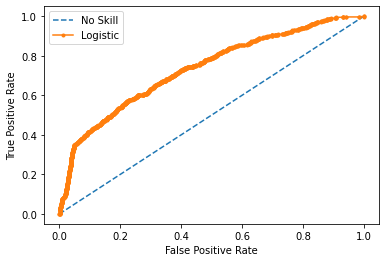

In [240]:
import numpy as np
from sklearn import metrics

predictions = trainer.predict(model, valid_loader)

y=[]
scores=[]
for (y_pred, y_true, auc_score) in predictions[:]:
    
    #print(y_pred.shape, y_true.shape)
    
    y.append(y_true)
    scores.append(y_pred)


y = np.concatenate(y)
scores = np.concatenate(scores)

print(sum(y==1), len(y))
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
print('roc is: ', metrics.roc_auc_score(y, scores))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)

In [ ]:
print(type(predictions))
print(len(predictions))
print(type(predictions[0]))
print(len(predictions[0]))
print()
print()
print()
print()
print()
print()
print()



In [ ]:
def collate_fn(train_data):
    train_data.sort(key=lambda data: len(data), reverse=True)
    data_length = [len(data) for data in train_data]
    train_data =  torch.nn.utils.rnn.pad_sequence(train_data, batch_first=True, padding_value=0)
    return train_data, data_length

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=2, collate_fn=collate_fn)

for data, length in train_dataloader:
    print(data)
    print(length)

In [ ]:
for data, length in train_dataloader:
    data = rnn_utils.pack_padded_sequence(data, length, batch_first=True)
    print(data)

In [ ]:
net = nn.LSTM(1, 5, batch_first=True)


In [ ]:
train_data = MyData(train_x)
train_dataloader = DataLoader(train_data, batch_size=2, collate_fn=collate_fn)

flag = 0
for data, length in train_dataloader:
    data = torch.nn.utils.rnn.pack_padded_sequence(data, length, batch_first=True)
    output, hidden = net(data)
    if flag == 0:
        print(output)
        flag = 1